<a href="https://colab.research.google.com/github/ps-research/FinDex/blob/main/PPMI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

In [ ]:
# Load the JSON data
file_path = '/content/drive/MyDrive/EACL NEW DATA/EACL_26-FinancialDiscussionsDataset.json'

with open(file_path, 'r') as f:
    data = json.load(f)

print(f"Loaded {len(data)} samples from the dataset")
print(f"\nFirst sample ID: {data[0]['sample_id']}")
print(f"Number of intent labels in first sample: {len(data[0]['labels']['intent'])}")
print(f"Number of impact labels in first sample: {len(data[0]['labels']['impact'])}")

Loaded 2408 samples from the dataset

First sample ID: 0001
Number of intent labels in first sample: 2
Number of impact labels in first sample: 3


In [ ]:
# Extract all unique intent and impact labels
all_intent_labels = set()
all_impact_labels = set()

for sample in data:
    all_intent_labels.update(sample['labels']['intent'])
    all_impact_labels.update(sample['labels']['impact'])

# Sort for consistent ordering
intent_labels = sorted(list(all_intent_labels))
impact_labels = sorted(list(all_impact_labels))

print("Intent Labels:")
for i, label in enumerate(intent_labels, 1):
    print(f"  {i}. {label}")

print(f"\nImpact Labels:")
for i, label in enumerate(impact_labels, 1):
    print(f"  {i}. {label}")

print(f"\nFound {len(intent_labels)} intent labels and {len(impact_labels)} impact labels")

Intent Labels:
  1. Advocacy & Warning
  2. Community Building & Solidarity Seeking
  3. Emotional & Esteem Support-Seeking
  4. Informational Help-Seeking
  5. Instrumental Help-Seeking
  6. Sense-Making & Narrative Construction
  7. Venting / Catharsis

Impact Labels:
  1. Behavioral Impact (Maladaptive Coping)
  2. Cognitive Impact
  3. Economic & Material Impact
  4. Physical Health Impact
  5. Psychological & Emotional Impact
  6. Relational & Social Impact

Found 7 intent labels and 6 impact labels


In [ ]:
# Count individual label occurrences
intent_counts = Counter()
impact_counts = Counter()

# Count co-occurrences
cooccurrence_counts = defaultdict(int)

# Total number of posts
N = len(data)

for sample in data:
    intents = sample['labels']['intent']
    impacts = sample['labels']['impact']

    # Count individual labels
    for intent in intents:
        intent_counts[intent] += 1
    for impact in impacts:
        impact_counts[impact] += 1

    # Count co-occurrences (all pairwise combinations in this post)
    for intent in intents:
        for impact in impacts:
            cooccurrence_counts[(intent, impact)] += 1

print(f"Total posts (N): {N}")
print(f"\nIntent Label Counts:")
for label in intent_labels:
    print(f"  {label}: {intent_counts[label]}")

print(f"\nImpact Label Counts:")
for label in impact_labels:
    print(f"  {label}: {impact_counts[label]}")

Total posts (N): 2408

Intent Label Counts:
  Advocacy & Warning: 611
  Community Building & Solidarity Seeking: 643
  Emotional & Esteem Support-Seeking: 767
  Informational Help-Seeking: 796
  Instrumental Help-Seeking: 515
  Sense-Making & Narrative Construction: 789
  Venting / Catharsis: 952

Impact Label Counts:
  Behavioral Impact (Maladaptive Coping): 509
  Cognitive Impact: 697
  Economic & Material Impact: 1861
  Physical Health Impact: 669
  Psychological & Emotional Impact: 1989
  Relational & Social Impact: 1114


In [ ]:
# Create co-occurrence matrix as DataFrame
cooccurrence_matrix = pd.DataFrame(
    0,
    index=intent_labels,
    columns=impact_labels
)

for (intent, impact), count in cooccurrence_counts.items():
    cooccurrence_matrix.loc[intent, impact] = count

print("Co-occurrence Matrix:")
print(cooccurrence_matrix)

Co-occurrence Matrix:
                                         Behavioral Impact (Maladaptive Coping)  \
Advocacy & Warning                                                           92   
Community Building & Solidarity Seeking                                     112   
Emotional & Esteem Support-Seeking                                          178   
Informational Help-Seeking                                                   84   
Instrumental Help-Seeking                                                   120   
Sense-Making & Narrative Construction                                       162   
Venting / Catharsis                                                         268   

                                         Cognitive Impact  \
Advocacy & Warning                                    166   
Community Building & Solidarity Seeking               127   
Emotional & Esteem Support-Seeking                    173   
Informational Help-Seeking                            374   
Instrume

In [ ]:
# Calculate PPMI
ppmi_matrix = pd.DataFrame(
    0.0,
    index=intent_labels,
    columns=impact_labels
)

for intent in intent_labels:
    for impact in impact_labels:
        count_ij = cooccurrence_matrix.loc[intent, impact]
        count_i = intent_counts[intent]
        count_j = impact_counts[impact]

        # Handle zero counts
        if count_ij == 0:
            ppmi_matrix.loc[intent, impact] = 0.0
        else:
            # Calculate probabilities
            p_ij = count_ij / N
            p_i = count_i / N
            p_j = count_j / N

            # Calculate PMI
            pmi = np.log2(p_ij / (p_i * p_j))

            # Apply positive threshold
            ppmi = max(0.0, pmi)
            ppmi_matrix.loc[intent, impact] = ppmi

print("PPMI Matrix calculated!")
print("\nPPMI Matrix:")
print(ppmi_matrix.round(3))

PPMI Matrix calculated!

PPMI Matrix:
                                         Behavioral Impact (Maladaptive Coping)  \
Advocacy & Warning                                                        0.000   
Community Building & Solidarity Seeking                                   0.000   
Emotional & Esteem Support-Seeking                                        0.135   
Informational Help-Seeking                                                0.000   
Instrumental Help-Seeking                                                 0.141   
Sense-Making & Narrative Construction                                     0.000   
Venting / Catharsis                                                       0.413   

                                         Cognitive Impact  \
Advocacy & Warning                                  0.000   
Community Building & Solidarity Seeking             0.000   
Emotional & Esteem Support-Seeking                  0.000   
Informational Help-Seeking                          0

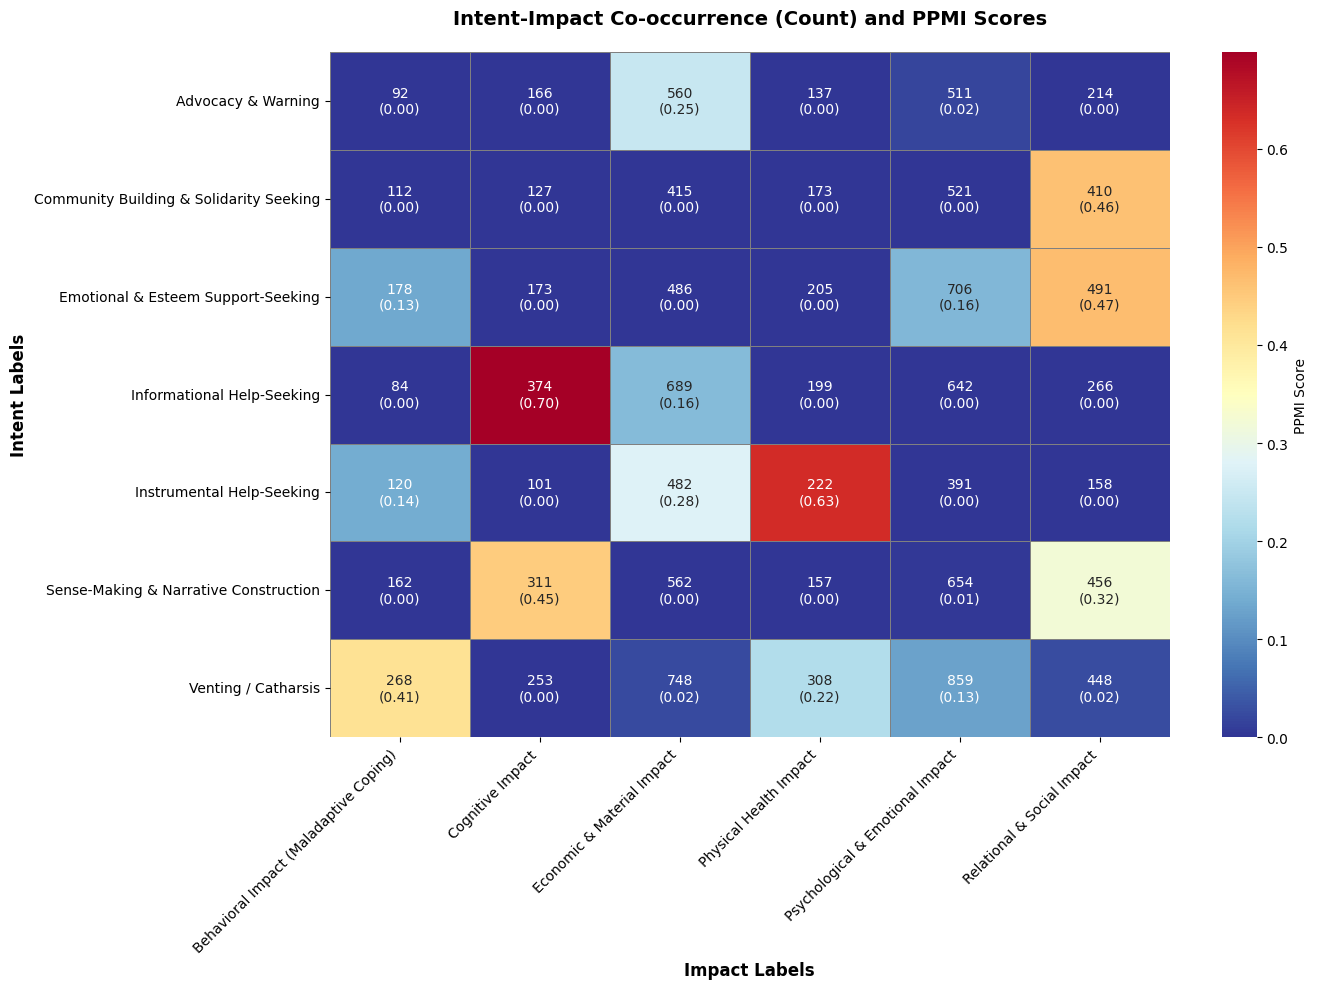

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create annotations combining co-occurrence counts and PPMI
annotations = []
for i, intent in enumerate(intent_labels):
    row = []
    for j, impact in enumerate(impact_labels):
        count = int(cooccurrence_matrix.loc[intent, impact])
        ppmi = ppmi_matrix.loc[intent, impact]
        # Format: count on top, PPMI in parentheses below
        text = f"{count}\n({ppmi:.2f})"
        row.append(text)
    annotations.append(row)

# Create heatmap based on PPMI values
sns.heatmap(
    ppmi_matrix.astype(float),
    annot=annotations,
    fmt='',
    cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (red for high values)
    cbar_kws={'label': 'PPMI Score'},
    ax=ax,
    linewidths=0.5,
    linecolor='gray',
    square=False,
    xticklabels=impact_labels,
    yticklabels=intent_labels
)

# Customize labels
ax.set_xlabel('Impact Labels', fontsize=12, fontweight='bold')
ax.set_ylabel('Intent Labels', fontsize=12, fontweight='bold')
ax.set_title('Intent-Impact Co-occurrence (Count) and PPMI Scores',
             fontsize=14, fontweight='bold', pad=20)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics
print("=" * 60)
print("PPMI ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nDataset Size: {N} posts")

print(f"\nPPMI Score Statistics:")
ppmi_values = ppmi_matrix.values.flatten()
print(f"  Mean PPMI: {ppmi_values.mean():.3f}")
print(f"  Median PPMI: {np.median(ppmi_values):.3f}")
print(f"  Max PPMI: {ppmi_values.max():.3f}")
print(f"  Min PPMI: {ppmi_values.min():.3f}")
print(f"  Std Dev: {ppmi_values.std():.3f}")

print(f"\nTop 10 Strongest Associations (Highest PPMI):")
# Flatten and find top associations
ppmi_flat = []
for intent in intent_labels:
    for impact in impact_labels:
        ppmi_flat.append((intent, impact, ppmi_matrix.loc[intent, impact]))

ppmi_flat.sort(key=lambda x: x[2], reverse=True)
for i, (intent, impact, ppmi) in enumerate(ppmi_flat[:10], 1):
    count = int(cooccurrence_matrix.loc[intent, impact])
    print(f"  {i}. {intent} × {impact}")
    print(f"     PPMI: {ppmi:.3f}, Count: {count}")

print(f"\nWeakest Associations (PPMI = 0):")
zero_ppmi = [(intent, impact) for intent, impact, ppmi in ppmi_flat if ppmi == 0]
print(f"  Found {len(zero_ppmi)} pairs with PPMI = 0 (co-occur less than random)")

PPMI ANALYSIS SUMMARY

Dataset Size: 2408 posts

PPMI Score Statistics:
  Mean PPMI: 0.119
  Median PPMI: 0.000
  Max PPMI: 0.699
  Min PPMI: 0.000
  Std Dev: 0.189

Top 10 Strongest Associations (Highest PPMI):
  1. Informational Help-Seeking × Cognitive Impact
     PPMI: 0.699, Count: 374
  2. Instrumental Help-Seeking × Physical Health Impact
     PPMI: 0.634, Count: 222
  3. Emotional & Esteem Support-Seeking × Relational & Social Impact
     PPMI: 0.469, Count: 491
  4. Community Building & Solidarity Seeking × Relational & Social Impact
     PPMI: 0.463, Count: 410
  5. Sense-Making & Narrative Construction × Cognitive Impact
     PPMI: 0.445, Count: 311
  6. Venting / Catharsis × Behavioral Impact (Maladaptive Coping)
     PPMI: 0.413, Count: 268
  7. Sense-Making & Narrative Construction × Relational & Social Impact
     PPMI: 0.321, Count: 456
  8. Instrumental Help-Seeking × Economic & Material Impact
     PPMI: 0.276, Count: 482
  9. Advocacy & Warning × Economic & Material 